In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDAS').getOrCreate()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pyspark.pandas as ps
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/12 09:16:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window

# Data Understanding

In [3]:
airline = spark.read.csv('train.csv', header=True, inferSchema=True)
print("The shape of data is: ({0},{1})".format(airline.count(),len(airline.columns)))
airline.limit(5).toPandas()

The shape of data is: (103904,24)


id  Gender      Customer Type  Age   Type of Travel     Class  \
0   70172    Male     Loyal Customer   13  Personal Travel  Eco Plus   
1    5047    Male  disloyal Customer   25  Business travel  Business   
2  110028  Female     Loyal Customer   26  Business travel  Business   
3   24026  Female     Loyal Customer   25  Business travel  Business   
4  119299    Male     Loyal Customer   61  Business travel  Business   

   Flight Distance  Inflight wifi service  Departure/Arrival time convenient  \
0              460                      3                                  4   
1              235                      3                                  2   
2             1142                      2                                  2   
3              562                      2                                  5   
4              214                      3                                  3   

   Ease of Online booking  ...  Inflight entertainment  On-board service  \
0                       3  ...                       5                 4   
1                       3  ...                       1                 1   
2                       2  ...                       5                 4   
3                       5  ...                       2                 2   
4                       3  ...                       3                 3   

   Leg room service  Baggage handling  Checkin service  Inflight service  \
0                 3                 4                4                 5   
1                 5                 3                1                 4   
2                 3                 4                4                 4   
3                 5                 3                1                 4   
4                 4                 4                3                 3   

   Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
0            5                          25                        18   
1            1                           1                         6   
2            5                           0                         0   
3            2                          11                         9   
4            3                           0                         0   

              satisfaction  
0  neutral or dissatisfied  
1  neutral or dissatisfied  
2                satisfied  
3  neutral or dissatisfied  
4                satisfied  

[5 rows x 24 columns]

In [4]:
airline.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- D

In [5]:
s = airline.groupBy('satisfaction').count().orderBy('satisfaction')
df_satisfaction = s.withColumn("Percentage(%)",f.round(f.col('count')/f.sum('count').over(Window.partitionBy())*100,2))
y, x= df_satisfaction.select('satisfaction').collect(), df_satisfaction.select('count').collect()
df_satisfaction.show()


22/10/12 09:17:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/12 09:17:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/12 09:17:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/12 09:17:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/12 09:17:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+-----+-------------+
|        satisfaction|count|Percentage(%)|
+--------------------+-----+-------------+
|neutral or dissat...|58879|        56.67|
|           satisfied|45025|        43.33|
+--------------------+-----+-------------+



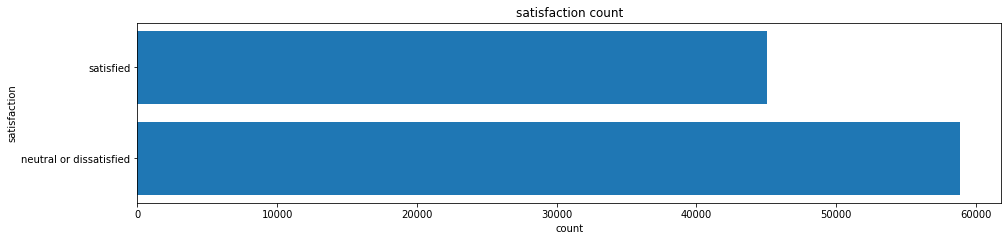

In [6]:
fig = plt.figure(figsize = (12,2.5))
ax = fig.add_axes([0,0,1,1])
ax.barh(np.array(y).flatten(),np.array(x).flatten())
ax.set_yticks(np.array(y).flatten())
ax.set_ylabel('satisfaction')
ax.set_xlabel('count')
ax.set_title('satisfaction count')
plt.show()

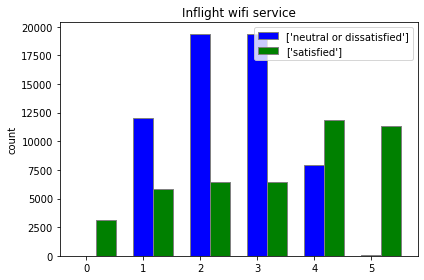

In [7]:
wifi = np.array(airline.groupBy('Inflight wifi service','satisfaction').
                count().groupBy('satisfaction').pivot('Inflight wifi service').
                sum("count").orderBy('satisfaction').collect())
wifi
labels = ['0','1','2','3','4','5']
neutral_dis = wifi[0,1:].astype('int')
satis = wifi[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 
br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots()
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =wifi[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =wifi[1,:1])

ax.set_ylabel('count')
ax.set_title('Inflight wifi service')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()


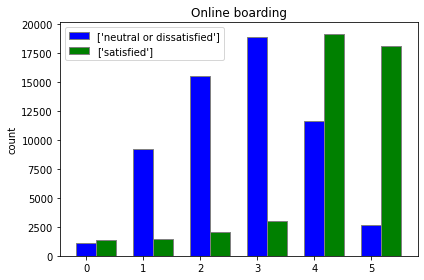

In [8]:
online_b = np.array(airline.groupBy('Online boarding','satisfaction').count().
                groupBy('satisfaction').pivot('Online boarding').sum("count").
                orderBy('satisfaction').collect())
online_b
labels = ['0','1','2','3','4','5']
neutral_dis = online_b[0,1:].astype('int')
satis = online_b[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 
br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots()
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =online_b[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =online_b[1,:1])

ax.set_ylabel('count')
ax.set_title('Online boarding')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [9]:
clean = np.array(airline.groupBy('Cleanliness','satisfaction').count().
                groupBy('satisfaction').pivot('Cleanliness').sum("count").
                orderBy('satisfaction').collect())
clean

array([['neutral or dissatisfied', 12, 10705, 12696, 13961, 12629, 8876],
       ['satisfied', None, 2613, 3436, 10613, 14550, 13813]], dtype=object)

In [10]:
clean[1,1:]

array([None, 2613, 3436, 10613, 14550, 13813], dtype=object)

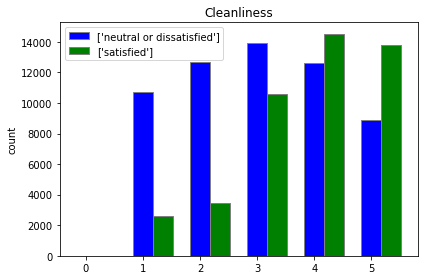

In [11]:
labels = ['0','1','2','3','4','5']
neutral_dis = clean[0,1:].astype('int')
clean[1,1]=0
satis = clean[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels))  

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots()
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =clean[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =clean[1,:1])

ax.set_ylabel('count')
ax.set_title('Cleanliness')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

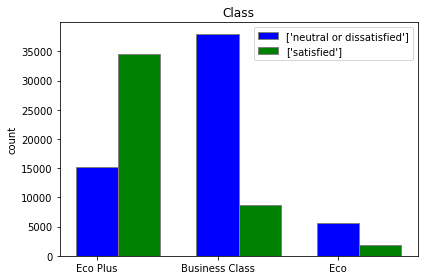

In [12]:
Class = np.array(airline.groupBy('Class','satisfaction').count().
                groupBy('satisfaction').pivot('Class').sum("count").
                orderBy('satisfaction').collect())
Class
labels = ['Eco Plus','Business Class','Eco']
neutral_dis = Class[0,1:].astype('int')
satis = Class[1,1:].astype('int')
width = 0.35  

x = np.arange(len(labels)) 

br1 = np.arange(len(neutral_dis))
br2 = [x + width for x in br1]

fig, ax = plt.subplots()
plt.bar(br1, neutral_dis, color ='b', width = width,
        edgecolor ='grey', label =Class[0,:1])
plt.bar(br2, satis, color ='g', width = width,
        edgecolor ='grey', label =Class[1,:1])

ax.set_ylabel('count')
ax.set_title('Class')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

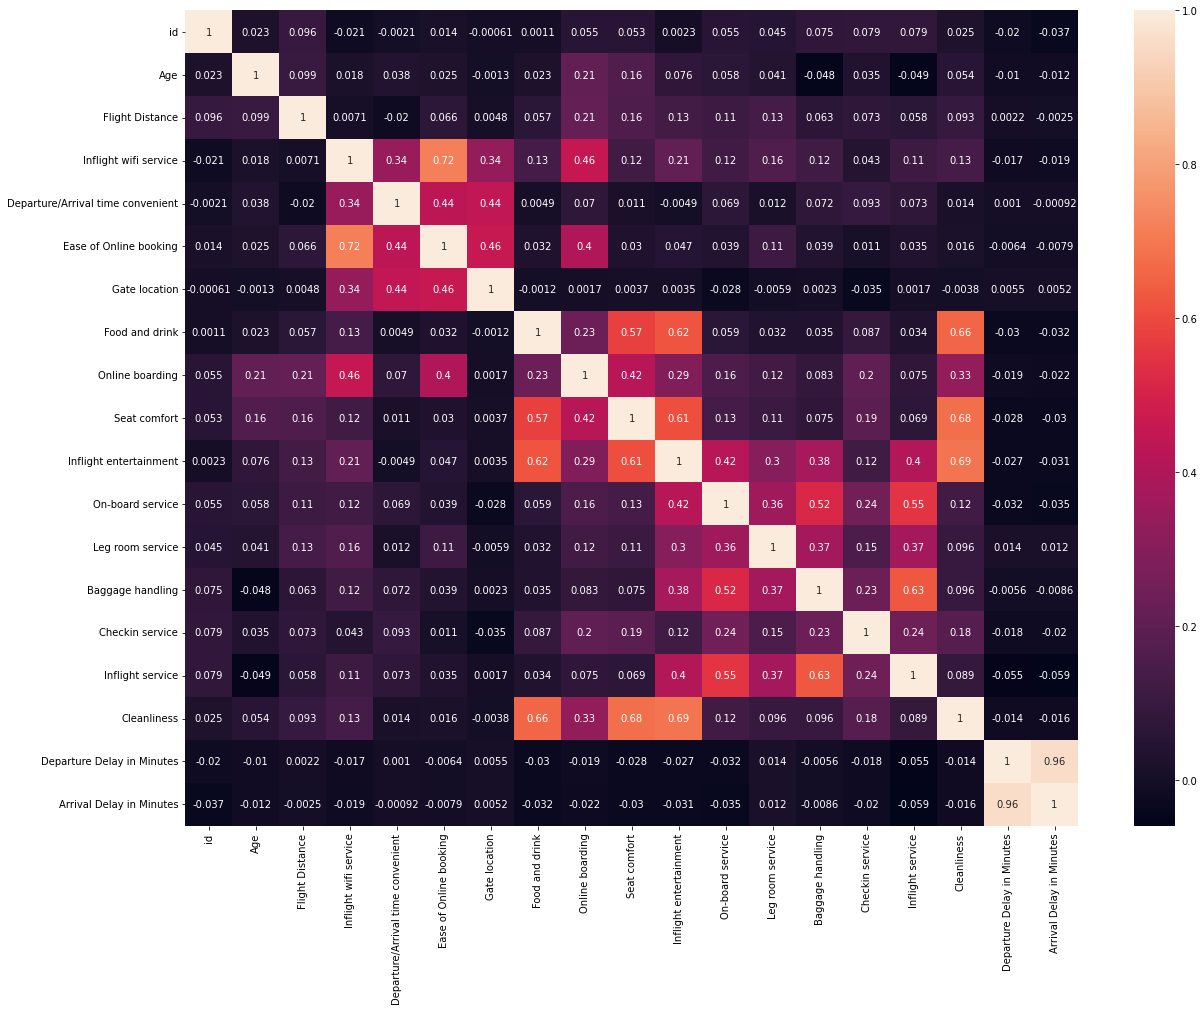

In [13]:
correlation_map = airline.toPandas().corr()
top_feature = correlation_map.index
plt.figure(figsize=(20,15))
sns.heatmap(airline.toPandas()[top_feature].corr(),annot=True)
plt.show

In [14]:
from pyspark.sql.functions import isnan,when,count,col
airline_count = airline.count()
airline.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in airline.columns]).show()


+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
| id|Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction|
+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+------------------

In [15]:
print("The shape of data is: ({0},{1})".format(airline.count(),len(airline.columns)))

The shape of data is: (103904,24)


In [16]:
completeness = (103904-0)/103904
print(completeness)

1.0


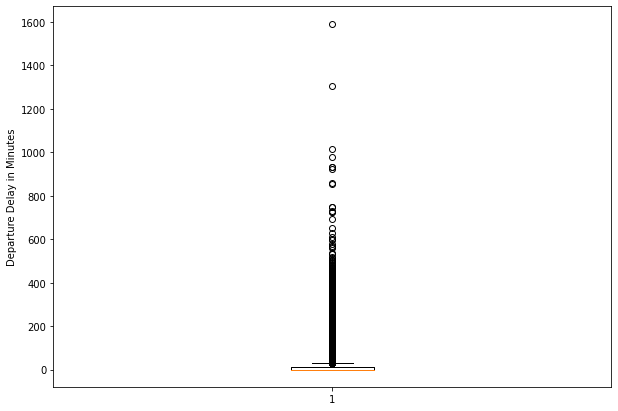

In [17]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(airline.toPandas()['Departure Delay in Minutes'])
plt.ylabel('Departure Delay in Minutes')
plt.show()


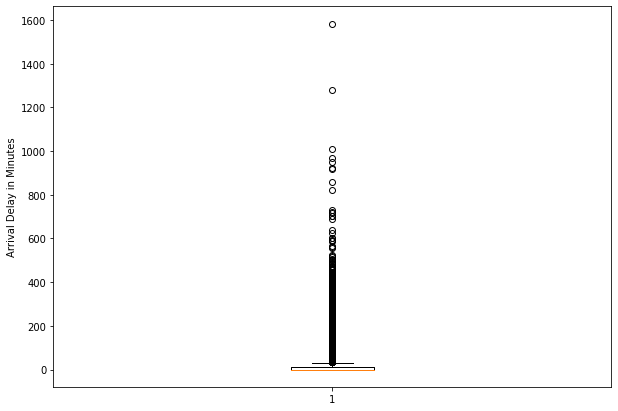

In [18]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(airline.toPandas()['Arrival Delay in Minutes'])
plt.ylabel('Arrival Delay in Minutes')
plt.show()

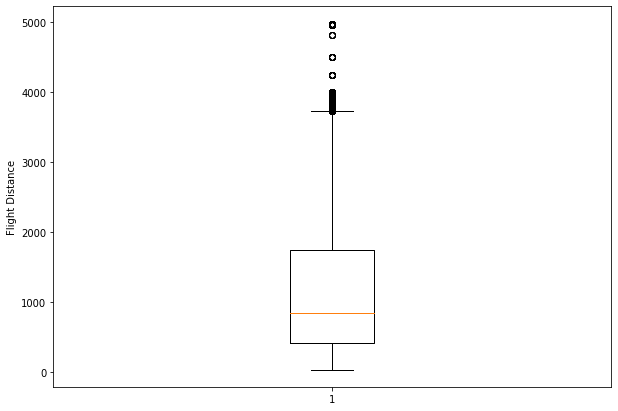

In [19]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(airline.toPandas()['Flight Distance'])
plt.ylabel('Flight Distance')
plt.show()

# Data Preparation

In [20]:
airline_clean = airline.drop('id', 'Age')

In [21]:
for col in airline_clean.dtypes:
    print(col[0])

Gender
Customer Type
Type of Travel
Class
Flight Distance
Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
Cleanliness
Departure Delay in Minutes
Arrival Delay in Minutes
satisfaction


In [22]:
print("The shape of data is: ({0},{1})".format(airline.count(),len(airline.columns)))

The shape of data is: (103904,24)


In [23]:
airline_clean.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Departure Delay in Minutes: integer (nullable = true)
 |-- Arrival Delay

In [24]:
airline_clean = airline_clean.withColumn('Inflight wifi service',airline_clean['Inflight wifi service'].cast('string'))
airline_clean = airline_clean.withColumn('Ease of Online booking',airline_clean['Ease of Online booking'].cast('string'))
airline_clean = airline_clean.withColumn('Gate location',airline_clean['Gate location'].cast('string'))
airline_clean = airline_clean.withColumn('Food and drink',airline_clean['Food and drink'].cast('string'))
airline_clean = airline_clean.withColumn('Online boarding',airline_clean['Online boarding'].cast('string'))
airline_clean = airline_clean.withColumn('Seat comfort',airline_clean['Seat comfort'].cast('string'))
airline_clean = airline_clean.withColumn('Inflight entertainment',
                                         airline_clean['Inflight entertainment'].cast('string'))
airline_clean = airline_clean.withColumn('On-board service',airline_clean['On-board service'].cast('string'))
airline_clean = airline_clean.withColumn('Leg room service',airline_clean['Leg room service'].cast('string'))
airline_clean = airline_clean.withColumn('Baggage handling',airline_clean['Baggage handling'].cast('string'))
airline_clean = airline_clean.withColumn('Checkin service',airline_clean['Checkin service'].cast('string'))                                                                          
airline_clean = airline_clean.withColumn('Inflight service',airline_clean['Inflight service'].cast('string'))                                                                          
airline_clean = airline_clean.withColumn('Cleanliness',airline_clean['Cleanliness'].cast('string'))    
airline_clean = airline_clean.withColumn('Departure/Arrival time convenient',
                                         airline_clean['Departure/Arrival time convenient'].cast('string'))  



In [25]:
airline_clean.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: string (nullable = true)
 |-- Departure/Arrival time convenient: string (nullable = true)
 |-- Ease of Online booking: string (nullable = true)
 |-- Gate location: string (nullable = true)
 |-- Food and drink: string (nullable = true)
 |-- Online boarding: string (nullable = true)
 |-- Seat comfort: string (nullable = true)
 |-- Inflight entertainment: string (nullable = true)
 |-- On-board service: string (nullable = true)
 |-- Leg room service: string (nullable = true)
 |-- Baggage handling: string (nullable = true)
 |-- Checkin service: string (nullable = true)
 |-- Inflight service: string (nullable = true)
 |-- Cleanliness: string (nullable = true)
 |-- Departure Delay in Minutes: integer (nullable = true)
 |-- Arrival Delay in Minutes: i

In [26]:
from pyspark.sql.functions import isnan,when,count,col
airline_clean_count = airline_clean.count()
airline_clean.select([count(when(isnan(c)| col(c).isNull(),c)).alias(c) for c in airline_clean.columns]).show()


+------+-------------+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|Gender|Customer Type|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction|
+------+-------------+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+--

In [27]:
import pyspark.sql.functions as f
from pyspark.sql.types import *
def DepartureDelayRemark(value):
    if   value <= 45: 
        return '0'
    elif value > 45:
        return '1'

In [28]:
depart= f.udf(DepartureDelayRemark,StringType())
airline_clean = airline_clean.withColumn('Departure_Delay', 
                                         depart('Departure Delay in Minutes'))


In [29]:
airline_clean.select(col("Departure Delay in Minutes"),col('Departure_Delay')).show(20)

+--------------------------+---------------+
|Departure Delay in Minutes|Departure_Delay|
+--------------------------+---------------+
|                        25|              0|
|                         1|              0|
|                         0|              0|
|                        11|              0|
|                         0|              0|
|                         0|              0|
|                         9|              0|
|                         4|              0|
|                         0|              0|
|                         0|              0|
|                         0|              0|
|                         0|              0|
|                        28|              0|
|                         0|              0|
|                        43|              0|
|                         1|              0|
|                        49|              1|
|                         0|              0|
|                         7|              0|
|         

In [30]:
def ArrivalDelayRemark(value):
    if   value <= 45: 
        return '0'
    elif value > 45:
        return '1'

In [31]:
Arrival= f.udf(ArrivalDelayRemark,StringType())
airline_clean = airline_clean.withColumn('Arrival_Delay', Arrival('Arrival Delay in Minutes'))

In [32]:
airline_clean.select(col("Arrival Delay in Minutes"),col('Arrival_Delay')).show(20)

+------------------------+-------------+
|Arrival Delay in Minutes|Arrival_Delay|
+------------------------+-------------+
|                      18|            0|
|                       6|            0|
|                       0|            0|
|                       9|            0|
|                       0|            0|
|                       0|            0|
|                      23|            0|
|                       0|            0|
|                       0|            0|
|                       0|            0|
|                       0|            0|
|                       0|            0|
|                       8|            0|
|                       0|            0|
|                      35|            0|
|                       0|            0|
|                      51|            1|
|                      10|            0|
|                       5|            0|
|                      18|            0|
+------------------------+-------------+
only showing top

In [33]:
airline_new = airline_clean.withColumn('satisfaction', 
                                       f.when(f.col('satisfaction') == 'satisfied', '1')
                                       .otherwise('0'))

In [34]:
airline_clean.select('satisfaction').show(10)

+--------------------+
|        satisfaction|
+--------------------+
|neutral or dissat...|
|neutral or dissat...|
|           satisfied|
|neutral or dissat...|
|           satisfied|
|neutral or dissat...|
|neutral or dissat...|
|           satisfied|
|neutral or dissat...|
|neutral or dissat...|
+--------------------+
only showing top 10 rows



In [35]:
airline_new.select('satisfaction').show(10)

+------------+
|satisfaction|
+------------+
|           0|
|           0|
|           1|
|           0|
|           1|
|           0|
|           0|
|           1|
|           0|
|           0|
+------------+
only showing top 10 rows



In [36]:
print(np.array(airline_clean.select('Gender').distinct().collect()).flatten())
print(np.array(airline_clean.select('Customer Type').distinct().collect()).flatten())
print(np.array(airline_clean.select('Type of Travel').distinct().collect()).flatten())
print(np.array(airline_clean.select('Class').distinct().collect()).flatten())

['Female' 'Male']
['Loyal Customer' 'disloyal Customer']
['Personal Travel' 'Business travel']
['Eco Plus' 'Business' 'Eco']


In [37]:
airline_clean = airline_clean.withColumnRenamed("Customer Type","Customer_Type") \
    .withColumnRenamed("Type of Travel","Type_of_Travel")

In [38]:
airline_new = airline_clean

In [39]:
airline_new = airline_new.withColumn('Gender', 
                                       f.when(f.col('Gender') == 'Female', '1')
                                       .otherwise('0'))

In [40]:
airline_new = airline_new.withColumn('Customer_Type', 
                                       f.when(f.col('Customer_Type') == 'Loyal Customer', '1')
                                       .otherwise('0'))

In [41]:
airline_new = airline_new.withColumn('Type_of_Travel', 
                                       f.when(f.col('Type_of_Travel') == 'Personal Travel',
                                              '1').otherwise('0'))


In [42]:
from pyspark.ml.feature import StringIndexer

In [43]:
def Class_reclassify(x):
    if x == 'Eco':
        return '0'
    if x == 'Eco Plus':
        return '1'
    if x == 'Business':
        return '2'

In [44]:
class_re = f.udf(Class_reclassify,StringType())
airline_new = airline_new.withColumn('Class',class_re('Class'))

In [45]:
airline_clean.select(col('Gender'),col('Customer_Type'),col('Type_of_Travel'),
                     col('Class')).show(10)

+------+-----------------+---------------+--------+
|Gender|    Customer_Type| Type_of_Travel|   Class|
+------+-----------------+---------------+--------+
|  Male|   Loyal Customer|Personal Travel|Eco Plus|
|  Male|disloyal Customer|Business travel|Business|
|Female|   Loyal Customer|Business travel|Business|
|Female|   Loyal Customer|Business travel|Business|
|  Male|   Loyal Customer|Business travel|Business|
|Female|   Loyal Customer|Personal Travel|     Eco|
|  Male|   Loyal Customer|Personal Travel|     Eco|
|Female|   Loyal Customer|Business travel|Business|
|Female|   Loyal Customer|Business travel|Business|
|  Male|disloyal Customer|Business travel|     Eco|
+------+-----------------+---------------+--------+
only showing top 10 rows



In [46]:
airline_new.select(col('Gender'),col('Customer_Type'),col('Type_of_Travel'),
                     col('Class')).show(10)

+------+-------------+--------------+-----+
|Gender|Customer_Type|Type_of_Travel|Class|
+------+-------------+--------------+-----+
|     0|            1|             1|    1|
|     0|            0|             0|    2|
|     1|            1|             0|    2|
|     1|            1|             0|    2|
|     0|            1|             0|    2|
|     1|            1|             1|    0|
|     0|            1|             1|    0|
|     1|            1|             0|    2|
|     1|            1|             0|    2|
|     0|            0|             0|    0|
+------+-------------+--------------+-----+
only showing top 10 rows



Traceback (most recent call last):
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [47]:
airline_test = spark.read.csv('textdata.csv', header=True, inferSchema=True)
airline_all = airline_new.union(airline_test)

In [48]:
print("The shape of data is: ({0},{1})".format(airline_new.count(),len(airline_new.columns)))

The shape of data is: (103904,24)


In [49]:
print("The shape of data is: ({0},{1})".format(airline_all.count(),len(airline_all.columns)))

The shape of data is: (106903,24)


In [50]:
airline_all = airline_all.withColumn('satisfaction', 
                                       f.when(f.col('satisfaction') == 'satisfied', '1')
                                       .otherwise('0'))

# Data transformation

In [51]:
airline_all.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Type_of_Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: string (nullable = true)
 |-- Departure/Arrival time convenient: string (nullable = true)
 |-- Ease of Online booking: string (nullable = true)
 |-- Gate location: string (nullable = true)
 |-- Food and drink: string (nullable = true)
 |-- Online boarding: string (nullable = true)
 |-- Seat comfort: string (nullable = true)
 |-- Inflight entertainment: string (nullable = true)
 |-- On-board service: string (nullable = true)
 |-- Leg room service: string (nullable = true)
 |-- Baggage handling: string (nullable = true)
 |-- Checkin service: string (nullable = true)
 |-- Inflight service: string (nullable = true)
 |-- Cleanliness: string (nullable = true)
 |-- Departure Delay in Minutes: integer (nullable = true)
 |-- Arrival Delay in Minutes: i

In [52]:
airline_tidy = airline_all.drop('Departure Delay in Minutes', 'Arrival Delay in Minutes')

In [53]:
airline_tidy = airline_tidy.drop('Flight Distance')

In [54]:
airline_tidy.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Type_of_Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Inflight wifi service: string (nullable = true)
 |-- Departure/Arrival time convenient: string (nullable = true)
 |-- Ease of Online booking: string (nullable = true)
 |-- Gate location: string (nullable = true)
 |-- Food and drink: string (nullable = true)
 |-- Online boarding: string (nullable = true)
 |-- Seat comfort: string (nullable = true)
 |-- Inflight entertainment: string (nullable = true)
 |-- On-board service: string (nullable = true)
 |-- Leg room service: string (nullable = true)
 |-- Baggage handling: string (nullable = true)
 |-- Checkin service: string (nullable = true)
 |-- Inflight service: string (nullable = true)
 |-- Cleanliness: string (nullable = true)
 |-- satisfaction: string (nullable = false)
 |-- Departure_Delay: string (nullable = true)
 |-- Arrival_Delay: string (nullable = true)



In [55]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [56]:
column = ['Gender',
             'Customer_Type',
             'Type_of_Travel',
             'Class',
             'Departure/Arrival time convenient',
             'Ease of Online booking',
             'Gate location',
             'Food and drink',
             'Online boarding',
             'Seat comfort',
             'Inflight entertainment',
             'On-board service',
             'Leg room service',
             'Baggage handling',
             'Inflight service',
             'Cleanliness',
             'Departure_Delay',
             'Arrival_Delay',
             'Inflight wifi service',
             'Checkin service',
             'satisfaction']
for i in column:
    indexer = StringIndexer(inputCol =i, outputCol= i+"Index" )
    model = indexer.fit(airline_tidy)
    indexed = model.transform(airline_tidy)
    airline_tidy = indexed

In [57]:
airline_tidy_up = airline_tidy.drop(*column)

In [58]:
airline_tidy_up.show(5)

+-----------+------------------+-------------------+----------+--------------------------------------+---------------------------+------------------+-------------------+--------------------+-----------------+---------------------------+---------------------+---------------------+---------------------+---------------------+----------------+--------------------+------------------+--------------------------+--------------------+-----------------+
|GenderIndex|Customer_TypeIndex|Type_of_TravelIndex|ClassIndex|Departure/Arrival time convenientIndex|Ease of Online bookingIndex|Gate locationIndex|Food and drinkIndex|Online boardingIndex|Seat comfortIndex|Inflight entertainmentIndex|On-board serviceIndex|Leg room serviceIndex|Baggage handlingIndex|Inflight serviceIndex|CleanlinessIndex|Departure_DelayIndex|Arrival_DelayIndex|Inflight wifi serviceIndex|Checkin serviceIndex|satisfactionIndex|
+-----------+------------------+-------------------+----------+--------------------------------------+--

In [59]:
airline_tidy_up

DataFrame[GenderIndex: double, Customer_TypeIndex: double, Type_of_TravelIndex: double, ClassIndex: double, Departure/Arrival time convenientIndex: double, Ease of Online bookingIndex: double, Gate locationIndex: double, Food and drinkIndex: double, Online boardingIndex: double, Seat comfortIndex: double, Inflight entertainmentIndex: double, On-board serviceIndex: double, Leg room serviceIndex: double, Baggage handlingIndex: double, Inflight serviceIndex: double, CleanlinessIndex: double, Departure_DelayIndex: double, Arrival_DelayIndex: double, Inflight wifi serviceIndex: double, Checkin serviceIndex: double, satisfactionIndex: double]

In [60]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorSlicer, MinMaxScaler, StandardScaler

In [61]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, \
    DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [62]:
vecAssembler = VectorAssembler(inputCols=airline_tidy_up.drop('satisfactionIndex').columns, outputCol='features')
data = vecAssembler.transform(airline_tidy_up)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
evaluator = MulticlassClassificationEvaluator(
    labelCol="satisfactionIndex", predictionCol="prediction", metricName="accuracy")
n_att = 20

rf = RandomForestClassifier(labelCol="satisfactionIndex", featuresCol="features",
                            numTrees=100, cacheNodeIds = True, subsamplingRate = 0.7)
pipe = Pipeline(stages = [rf])
mod = pipe.fit(trainingData)
feature_imp = mod.stages[-1].featureImportances
list_extract = []
for i in trainingData.schema['features'].metadata["ml_attr"]["attrs"]:
    list_extract = list_extract + trainingData.schema['features'].metadata["ml_attr"]["attrs"][i]
for i in range(len(list_extract)):
    list_extract[i]['score'] = feature_imp[i]
list_extract = sorted(list_extract, key = lambda x: x['score'], reverse = True)
list_features = [x['name'] for x in list_extract]


predictions = mod.transform(testData)
acc = evaluator.evaluate(predictions)

for i in range(n_att-1,n_att-5,-1):
    varidx = [x['idx'] for x in list_extract][:i]
    slicer = VectorSlicer(inputCol="features", outputCol="features2", indices = varidx)
    trainingData = slicer.transform(trainingData).withColumn('features', f.col('features2')).drop('features2')
    mod = pipe.fit(trainingData)
    feature_imp = mod.stages[-1].featureImportances
    
    list_extract = [{'idx':j, 'name':list_extract[varidx[j]]['name'], 'score':feature_imp[j]} 
                    for j in range(len(varidx))]
    list_extract = sorted(list_extract, key = lambda x: x['score'], reverse = True)
    
    testData = slicer.transform(testData).withColumn('features', f.col('features2')).drop('features2')
    predictions = mod.transform(testData)
    accuracy = evaluator.evaluate(predictions)
    if (accuracy > acc):
        acc, n_att = accuracy, i
        list_features = [x['name'] for x in list_extract]

print("Optimum number of features: {}".format(n_att))
print("Score with {} features: {:.6f}".format(n_att, acc))

print("Features selected:\n{}".format(list_features))


Optimum number of features: 17
Score with 17 features: 0.919056
Features selected:
['On-board serviceIndex', 'Arrival_DelayIndex', 'ClassIndex', 'Type_of_TravelIndex', 'CleanlinessIndex', 'Seat comfortIndex', 'Ease of Online bookingIndex', 'Baggage handlingIndex', 'Inflight serviceIndex', 'Inflight wifi serviceIndex', 'Food and drinkIndex', 'Checkin serviceIndex', 'Departure/Arrival time convenientIndex', 'Customer_TypeIndex', 'Leg room serviceIndex', 'GenderIndex', 'Inflight entertainmentIndex']


In [63]:
from pyspark.sql.functions import col, explode, array, lit
df_0 = airline_tidy_up.filter(col("satisfactionIndex") == 0)
df_1 = airline_tidy_up.filter(col("satisfactionIndex") == 1)
print(df_0.count(),df_1.count())

61878 45025


In [64]:
df_a = airline_tidy_up.filter(col("satisfactionIndex") == 0)
df_b = airline_tidy_up.filter(col("satisfactionIndex") == 1)

a_count = df_a.count()
b_count = df_b.count() 
ratio = a_count / b_count

airline_tidy_up_overampled = df_b.sample(withReplacement=True, fraction=ratio, seed=1)
airline_upsample = df_a.unionAll(airline_tidy_up_overampled)

In [65]:
df_0 = airline_upsample.filter(col("satisfactionIndex") == 0)
df_1 = airline_upsample.filter(col("satisfactionIndex") == 1)
print(df_0.count(),df_1.count())

61878 61922


In [99]:
airline_upsample.toPandas().head(5)

GenderIndex  Customer_TypeIndex  Type_of_TravelIndex  ClassIndex  \
0          1.0                 0.0                  1.0         2.0   
1          1.0                 1.0                  0.0         0.0   
2          0.0                 0.0                  0.0         0.0   
3          0.0                 0.0                  1.0         1.0   
4          1.0                 0.0                  1.0         1.0   

   Departure/Arrival time convenientIndex  Ease of Online bookingIndex  \
0                                     0.0                          0.0   
1                                     3.0                          0.0   
2                                     1.0                          4.0   
3                                     0.0                          1.0   
4                                     0.0                          1.0   

   Gate locationIndex  Food and drinkIndex  Online boardingIndex  \
0                 3.0                  1.0                   1.0   
1                 0.0                  4.0                   1.0   
2                 4.0                  3.0                   3.0   
3                 3.0                  4.0                   3.0   
4                 0.0                  3.0                   3.0   

   Seat comfortIndex  ...  On-board serviceIndex  Leg room serviceIndex  \
0                1.0  ...                    0.0                    2.0   
1                4.0  ...                    4.0                    1.0   
2                3.0  ...                    3.0                    1.0   
3                4.0  ...                    2.0                    0.0   
4                3.0  ...                    2.0                    2.0   

   Baggage handlingIndex  Inflight serviceIndex  CleanlinessIndex  \
0                    0.0                    1.0               2.0   
1                    2.0                    0.0               4.0   
2                    2.0                    0.0               3.0   
3                    0.0                    0.0               4.0   
4                    0.0                    1.0               3.0   

   Departure_DelayIndex  Arrival_DelayIndex  Inflight wifi serviceIndex  \
0                   0.0                 0.0                         0.0   
1                   0.0                 0.0                         0.0   
2                   0.0                 0.0                         1.0   
3                   0.0                 0.0                         0.0   
4                   0.0                 0.0                         1.0   

   Checkin serviceIndex  satisfactionIndex  
0                   0.0                0.0  
1                   3.0                0.0  
2                   3.0                0.0  
3                   0.0                0.0  
4                   1.0                0.0  

[5 rows x 21 columns]

In [100]:
print("The shape of data is: ({0},{1})".format(airline_upsample.count(),len(airline_upsample.columns)))


The shape of data is: (123800,21)


In [104]:
airline_upsample.printSchema()

root
 |-- GenderIndex: double (nullable = false)
 |-- Customer_TypeIndex: double (nullable = false)
 |-- Type_of_TravelIndex: double (nullable = false)
 |-- ClassIndex: double (nullable = false)
 |-- Departure/Arrival time convenientIndex: double (nullable = false)
 |-- Ease of Online bookingIndex: double (nullable = false)
 |-- Gate locationIndex: double (nullable = false)
 |-- Food and drinkIndex: double (nullable = false)
 |-- Online boardingIndex: double (nullable = false)
 |-- Seat comfortIndex: double (nullable = false)
 |-- Inflight entertainmentIndex: double (nullable = false)
 |-- On-board serviceIndex: double (nullable = false)
 |-- Leg room serviceIndex: double (nullable = false)
 |-- Baggage handlingIndex: double (nullable = false)
 |-- Inflight serviceIndex: double (nullable = false)
 |-- CleanlinessIndex: double (nullable = false)
 |-- Departure_DelayIndex: double (nullable = false)
 |-- Arrival_DelayIndex: double (nullable = false)
 |-- Inflight wifi serviceIndex: double

# Data mining algorithm selection

In [66]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [67]:
grid = ParamGridBuilder().build()
evaluator = MulticlassClassificationEvaluator(labelCol="satisfactionIndex", predictionCol="prediction", metricName="accuracy")

In [68]:
#Logistic Regression
scalar = StandardScaler(inputCol='features', outputCol='features2')
lr = LogisticRegression(labelCol="satisfactionIndex", featuresCol="features2")
pipeline_lr = Pipeline(stages = [scalar,lr])
scores_lr = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=grid, evaluator=evaluator).fit(trainingData)
scores_lr.avgMetrics[0]

22/10/12 09:20:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/10/12 09:20:07 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/12 09:20:07 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


0.8736687656092594

In [69]:
scores_lr.avgMetrics[0]

0.8736687656092594

In [70]:
#Decision Tree
scalar = StandardScaler(inputCol='features', outputCol='features2')
dt=DecisionTreeClassifier(labelCol="satisfactionIndex", featuresCol="features2")
pipeline_dt = Pipeline(stages = [scalar,dt])
scores_dt = CrossValidator(estimator=pipeline_dt, estimatorParamMaps=grid, evaluator=evaluator).fit(trainingData)
scores_dt.avgMetrics[0]

0.8995326659266265

In [71]:
#Random Forest
scalar = StandardScaler(inputCol='features', outputCol='features2')
rf=RandomForestClassifier(labelCol="satisfactionIndex", featuresCol="features2")
pipeline_rf = Pipeline(stages = [scalar,rf])
scores_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=grid, evaluator=evaluator).fit(trainingData)
scores_rf.avgMetrics[0]

0.9119747382251169

In [72]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [73]:
def confusion_matrix (amount, acc, class_ratio = 1.5, ratioCorrect=1.5):
    class_0 = round(amount/class_ratio)
    class_1 = amount - class_0
    correct = round(amount * acc)
    incorrect = amount - correct
    correct_0 = round(correct/ratioCorrect)
    correct_1 = correct - correct_0
    incorrect_0 = class_0 - correct_0
    incorrect_1 = class_1 - correct_1
    
    data = [
        ('Actual_0',correct_0, incorrect_0),
        ('Actual_1',incorrect_1,correct_1)
    ]
    
    schema = StructType([
        StructField("", StringType(), True),
        StructField("Predicted_0", IntegerType(), True),
        StructField("Predicted_1", IntegerType(), True)
    ])
    
    conf_mat = spark.createDataFrame(data=data,schema=schema)
    return conf_mat

def precision_acc(conf_mat, label = 1):
    try:
        conf_mat = np.array(conf_mat.collect())
        true_pos, false_pos, true_neg, false_neg = float(conf_mat[1,2]), float(conf_mat[0,2]), float(conf_mat[0,1]), float(conf_mat[1,1])
    except:
        true_pos, false_pos, true_neg, false_neg = float(conf_mat[1,1]), float(conf_mat[0,1]), float(conf_mat[0,0]), float(conf_mat[1,0])
    
    
    precision_0 = true_neg/(true_neg+false_neg)
    recall_0 = true_neg/(true_neg+false_pos)
    f1_0 = 2*((precision_0*recall_0)/(precision_0+recall_0))
    
    precision_1 = true_pos/(true_pos+false_pos)
    recall_1 = true_pos/(true_pos+false_neg)
    f1_1 = 2*((precision_1*recall_1)/(precision_1+recall_1))
    
    data = [
        ('0',round(precision_0,2), round(recall_0,2), round(f1_0,2)),
        ('1',round(precision_1,2), round(recall_1,2), round(f1_1,2))
    ]
    
    schema = StructType([
        StructField("", StringType(), True),
        StructField("precision", FloatType(), True),
        StructField("recall", FloatType(), True),
        StructField("f1", FloatType(), True)
    ])
    
    return spark.createDataFrame(data=data,schema=schema)


In [74]:
def getBestPrams(cvModel):
    best = max(list(zip(cvModel.avgMetrics, cvModel.getEstimatorParamMaps())), key = lambda x: x[0])
    return {k.name:v for k,v in best[1].items()}

In [75]:
vecAssembler = VectorAssembler(inputCols=airline_upsample.drop('satisfactionIndex').columns, outputCol='features')
data = vecAssembler.transform(airline_upsample)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())

86649


37151


In [76]:
def df_conf_mat(conf_mat):
    data = [
        ('Actual_0',int(conf_mat[0,0]), int(conf_mat[0,1])),
        ('Actual_1',int(conf_mat[1,0]), int(conf_mat[1,1]))
    ]
    
    schema = StructType([
        StructField("", StringType(), True),
        StructField("Predicted_0", IntegerType(), True),
        StructField("Predicted_1", IntegerType(), True)
    ])
    
    conf_mat = spark.createDataFrame(data=data,schema=schema)
    return conf_mat

# Logistic Regression

In [77]:
param_range_fl= [1.0, 0.5, 0.1]
grid = ParamGridBuilder().addGrid(lr.fitIntercept,[True, False]).addGrid(lr.regParam,param_range_fl).addGrid(lr.elasticNetParam,[0,1]).build()
evaluator =MulticlassClassificationEvaluator(labelCol="satisfactionIndex", 
                                              predictionCol="prediction", metricName="accuracy")

cvModel_lr =CrossValidator(estimator= pipeline_lr, estimatorParamMaps=grid, 
                            evaluator =evaluator, numFolds = 5).fit(trainingData)

predictions_lr = cvModel_lr.bestModel.transform(testData).select("satisfactionIndex", "prediction").withColumn('satisfactionIndex', f.col('satisfactionIndex').cast('double')).rdd
metrics = MulticlassMetrics(predictions_lr)

precision_acc(metrics.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics.accuracy,2)))

display("Best Parameters: {}".format(getBestPrams(cvModel_lr)))

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.87|  0.87|0.87|
|  1|     0.86|  0.87|0.87|
+---+---------+------+----+



'Accuracy: 0.87'

"Best Parameters: {'fitIntercept': True, 'regParam': 0.1, 'elasticNetParam': 0.0}"

In [78]:
df_conf_mat(metrics.confusionMatrix().toArray()).show()

precision_acc(metrics.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics.accuracy,2)))

+--------+-----------+-----------+
|        |Predicted_0|Predicted_1|
+--------+-----------+-----------+
|Actual_0|      16218|       2506|
|Actual_1|       2434|      15993|
+--------+-----------+-----------+

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.87|  0.87|0.87|
|  1|     0.86|  0.87|0.87|
+---+---------+------+----+



'Accuracy: 0.87'

<AxesSubplot:>

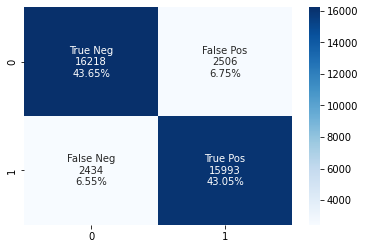

In [79]:
cf_matrix=metrics.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

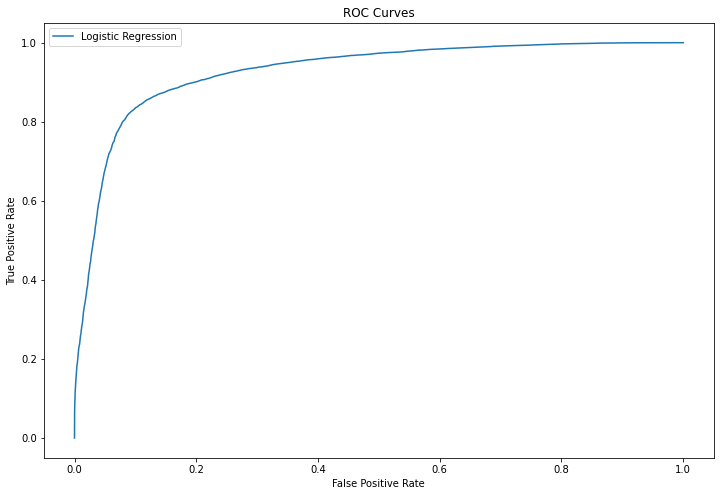

In [80]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_lr]:
    predictions = model.transform(testData).select("satisfactionIndex", "probability").withColumn('satisfactionIndex', f.col('satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Logistic Regression'])

In [81]:
lr = LogisticRegression(labelCol="satisfactionIndex", featuresCol="features",fitIntercept=True,regParam=0.1,elasticNetParam= 0)
model_lr = lr.fit(trainingData)
lr_i = model_lr.coefficients
importancesList=[float(col) for col in  lr_i]
colList = airline_upsample.columns
importances_lr=dict(zip(colList,importancesList))
print(importances_lr)


{'GenderIndex': 0.023118476435244627, 'Customer_TypeIndex': -0.8683517529425824, 'Type_of_TravelIndex': -1.2387390891779855, 'ClassIndex': -0.5906083008828904, 'Departure/Arrival time convenientIndex': 0.016436078002736068, 'Ease of Online bookingIndex': 0.11568511189514465, 'Gate locationIndex': -0.038924098513544884, 'Food and drinkIndex': -0.050319213661609866, 'Online boardingIndex': -0.17112722593813465, 'Seat comfortIndex': -0.12305882631513944, 'Inflight entertainmentIndex': -0.17437681021160262, 'On-board serviceIndex': -0.14578508847163707, 'Leg room serviceIndex': -0.18055389562793553, 'Baggage handlingIndex': -0.06600078414296616, 'Inflight serviceIndex': -0.050430971028329434, 'CleanlinessIndex': -0.041638783333556424, 'Departure_DelayIndex': -0.47980292246682366, 'Arrival_DelayIndex': 0.03668675019717034, 'Inflight wifi serviceIndex': 0.3844874217901723, 'Checkin serviceIndex': -0.0746165737059914}


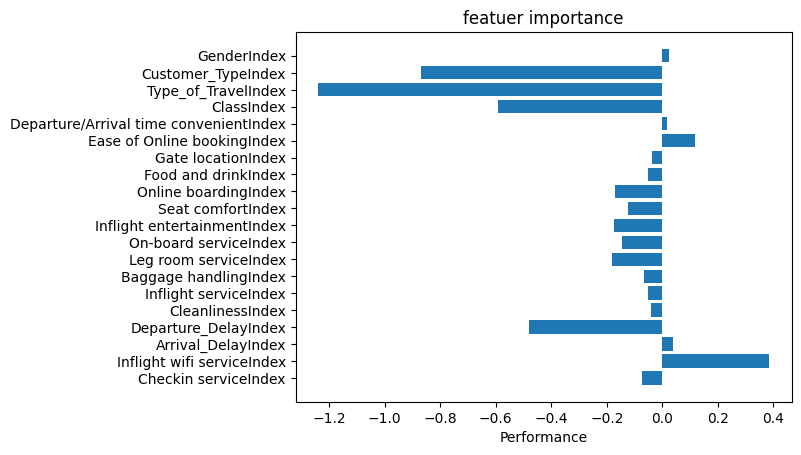

<Figure size 1000x700 with 0 Axes>

In [82]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig = plt.figure(figsize =(10, 7))
ax.barh(range(len(importances_lr)), importances_lr.values(), align='center')
ax.set_yticks(range(len(importances_lr)), labels=list(importances_lr.keys()))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('featuer importance')

plt.show()

# Decision Tree

In [83]:
grid = ParamGridBuilder().addGrid(dt.maxDepth, [10,15,20]).addGrid(dt.impurity,['gini','entropy']).build()
evaluator = MulticlassClassificationEvaluator(labelCol="satisfactionIndex", 
                                              predictionCol = "prediction", metricName = "accuracy")

cvModel_dt = CrossValidator(estimator=pipeline_dt, estimatorParamMaps = grid, 
                            evaluator =evaluator, numFolds = 3).fit(trainingData)

predictions_dt = cvModel_dt.bestModel.transform(testData).select("satisfactionIndex", "prediction").withColumn('satisfactionIndex', f.col('satisfactionIndex').cast('double')).rdd
metrics_dt = MulticlassMetrics(predictions_dt)

precision_acc(metrics_dt.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_dt.accuracy,2)))

display("Best Parameters: {}".format(getBestPrams(cvModel_dt)))


22/10/12 09:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.95|  0.96|0.95|
|  1|     0.96|  0.95|0.95|
+---+---------+------+----+



'Accuracy: 0.95'

"Best Parameters: {'maxDepth': 20, 'impurity': 'entropy'}"

In [84]:
df_conf_mat(metrics_dt.confusionMatrix().toArray()).show()

precision_acc(metrics_dt.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_dt.accuracy,2)))

+--------+-----------+-----------+
|        |Predicted_0|Predicted_1|
+--------+-----------+-----------+
|Actual_0|      17684|        771|
|Actual_1|        968|      17728|
+--------+-----------+-----------+

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.95|  0.96|0.95|
|  1|     0.96|  0.95|0.95|
+---+---------+------+----+



'Accuracy: 0.95'

<AxesSubplot:>

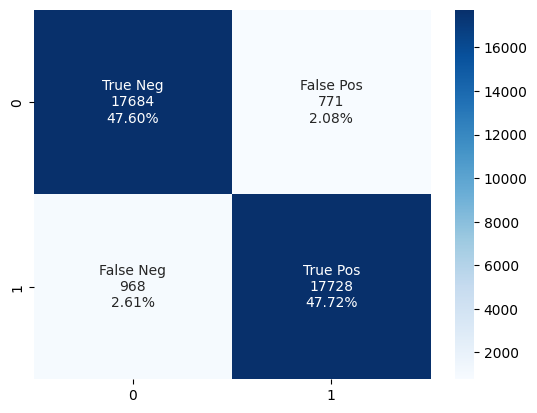

In [85]:
cf_matrix=metrics_dt.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

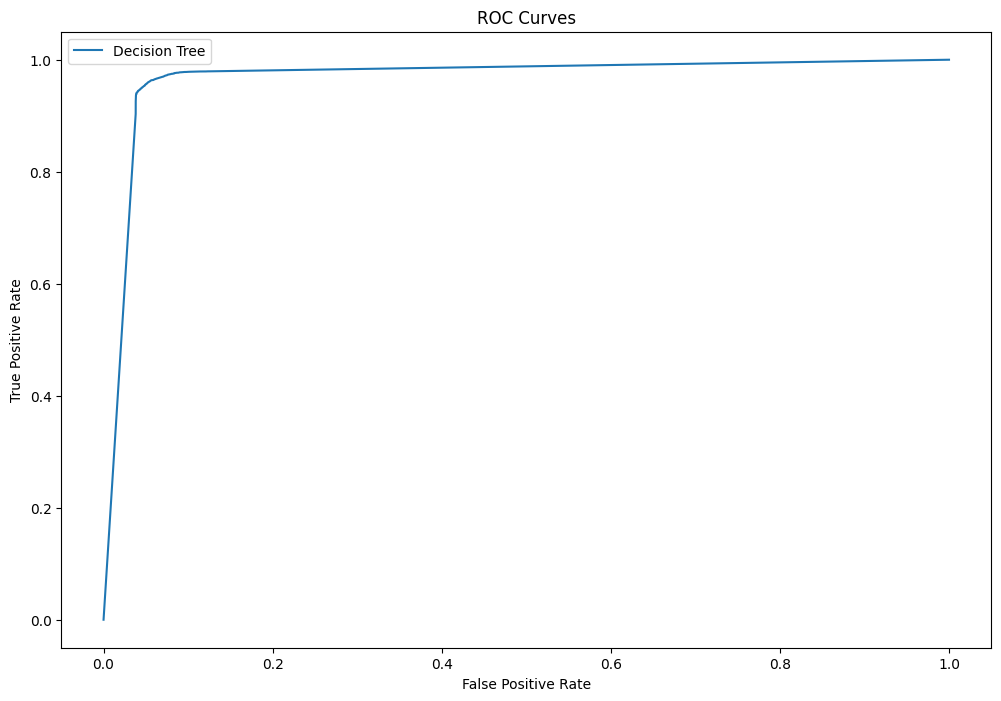

In [86]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_dt]:
    predictions = model.transform(testData).select("satisfactionIndex", "probability").withColumn('satisfactionIndex', f.col('satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Decision Tree'])

In [87]:
dt = DecisionTreeClassifier(labelCol="satisfactionIndex", featuresCol="features",maxDepth=20 )
model_dt = dt.fit(trainingData)
ff = model_dt.featureImportances
importancesList=[float(col) for col in  ff]
colList = airline_upsample.columns
importances_dt=dict(zip(colList,importancesList))
print(importances_dt)

22/10/12 09:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1044.1 KiB
22/10/12 09:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1123.4 KiB
22/10/12 09:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1198.8 KiB


{'GenderIndex': 0.00627672645843554, 'Customer_TypeIndex': 0.03234519283617857, 'Type_of_TravelIndex': 0.12689647632775333, 'ClassIndex': 0.03401696793665933, 'Departure/Arrival time convenientIndex': 0.01891764172466062, 'Ease of Online bookingIndex': 0.005982745880166178, 'Gate locationIndex': 0.026116696507451666, 'Food and drinkIndex': 0.012164479675956802, 'Online boardingIndex': 0.3569800410607678, 'Seat comfortIndex': 0.014024091093068328, 'Inflight entertainmentIndex': 0.04559907540855436, 'On-board serviceIndex': 0.014941928822774227, 'Leg room serviceIndex': 0.015412666145969369, 'Baggage handlingIndex': 0.022976442784959805, 'Inflight serviceIndex': 0.015767862224448183, 'CleanlinessIndex': 0.011449488354336986, 'Departure_DelayIndex': 0.010493150087377471, 'Arrival_DelayIndex': 0.013774030085250397, 'Inflight wifi serviceIndex': 0.18865656580040538, 'Checkin serviceIndex': 0.027207730784825607}


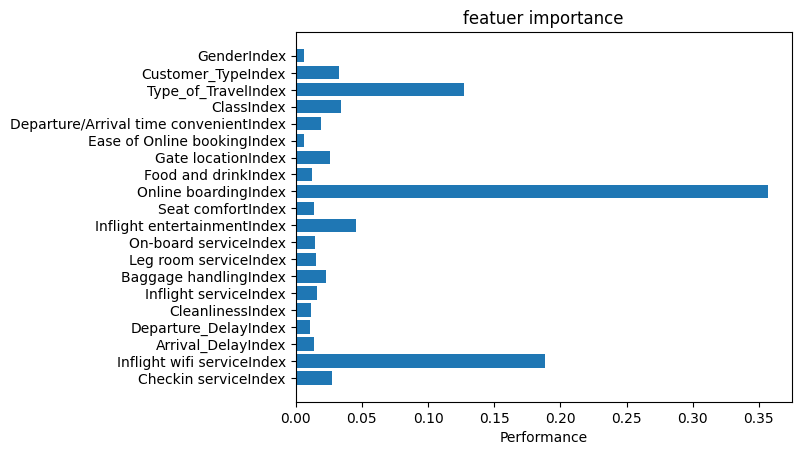

<Figure size 1000x700 with 0 Axes>

In [88]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig = plt.figure(figsize =(10, 7))
ax.barh(range(len(importances_dt)), importances_dt.values(), align='center')
ax.set_yticks(range(len(importances_dt)), labels=list(importances_dt.keys()))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('featuer importance')

plt.show()

In [95]:
model_dt.toDebugString

'DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e862f6bdca26, depth=20, numNodes=6459, numClasses=2, numFeatures=20\n  If (feature 8 in {1.0,3.0,4.0,5.0})\n   If (feature 18 in {0.0,1.0,3.0})\n    If (feature 3 in {1.0,2.0})\n     If (feature 2 in {1.0})\n      Predict: 0.0\n     Else (feature 2 not in {1.0})\n      If (feature 1 in {1.0})\n       If (feature 13 in {0.0,2.0,3.0,4.0})\n        If (feature 11 in {0.0,2.0,3.0,4.0})\n         If (feature 14 in {0.0,2.0,3.0,4.0})\n          If (feature 19 in {0.0,1.0,3.0,4.0})\n           If (feature 6 in {0.0,1.0,2.0,4.0})\n            If (feature 11 in {2.0,3.0,4.0})\n             Predict: 0.0\n            Else (feature 11 not in {2.0,3.0,4.0})\n             If (feature 12 in {0.0,2.0,4.0})\n              Predict: 0.0\n             Else (feature 12 not in {0.0,2.0,4.0})\n              If (feature 9 in {0.0,1.0,2.0})\n               Predict: 0.0\n              Else (feature 9 not in {0.0,1.0,2.0})\n               If (feature 7

# Random Forest

In [89]:
grid= ParamGridBuilder().addGrid(rf.maxDepth, [10,15,20]).addGrid(rf.impurity,['gini','entropy']).build()
evaluator = MulticlassClassificationEvaluator(labelCol="satisfactionIndex", 
                                              predictionCol="prediction", metricName="accuracy")

cvModel_rf =CrossValidator(estimator =pipeline_rf, estimatorParamMaps= grid, 
                            evaluator= evaluator, numFolds= 3).fit(trainingData)

predictions_rf = cvModel_rf.bestModel.transform(testData).select("satisfactionIndex", "prediction").withColumn('satisfactionIndex', f.col('satisfactionIndex').cast('double')).rdd
metrics_rf = MulticlassMetrics(predictions_dt)

precision_acc(metrics_rf.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_rf.accuracy,2)))

display("Best Parameters: {}".format(getBestPrams(cvModel_rf)))


22/10/12 09:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1287.9 KiB
22/10/12 09:29:32 WARN DAGScheduler: Broadcasting large task binary with size 1877.8 KiB
22/10/12 09:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1273.5 KiB
22/10/12 09:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1251.2 KiB
22/10/12 09:29:44 WARN DAGScheduler: Broadcasting large task binary with size 1804.0 KiB
22/10/12 09:29:45 WARN DAGScheduler: Broadcasting large task binary with size 1207.5 KiB
22/10/12 09:29:51 WARN DAGScheduler: Broadcasting large task binary with size 1287.9 KiB
22/10/12 09:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1877.8 KiB
22/10/12 09:29:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/10/12 09:29:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/10/12 09:29:57 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/10/12 09:29:59 WARN DAGSche

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.95|  0.96|0.95|
|  1|     0.96|  0.95|0.95|
+---+---------+------+----+



'Accuracy: 0.95'

"Best Parameters: {'maxDepth': 20, 'impurity': 'gini'}"

In [90]:
df_conf_mat(metrics_rf.confusionMatrix().toArray()).show()

precision_acc(metrics_rf.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_rf.accuracy,2)))

+--------+-----------+-----------+
|        |Predicted_0|Predicted_1|
+--------+-----------+-----------+
|Actual_0|      17684|        771|
|Actual_1|        968|      17728|
+--------+-----------+-----------+

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.95|  0.96|0.95|
|  1|     0.96|  0.95|0.95|
+---+---------+------+----+



'Accuracy: 0.95'

<AxesSubplot:>

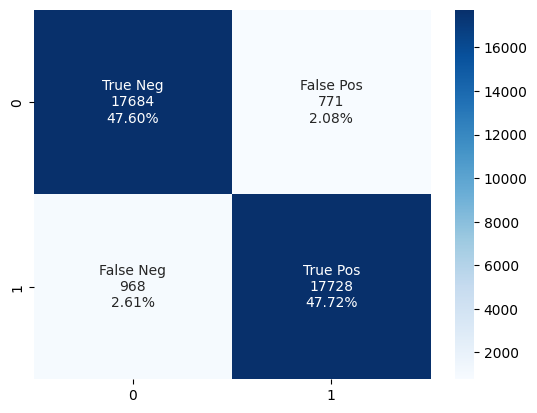

In [91]:
cf_matrix=metrics_rf.confusionMatrix().toArray()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

22/10/12 09:38:11 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/10/12 09:38:13 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


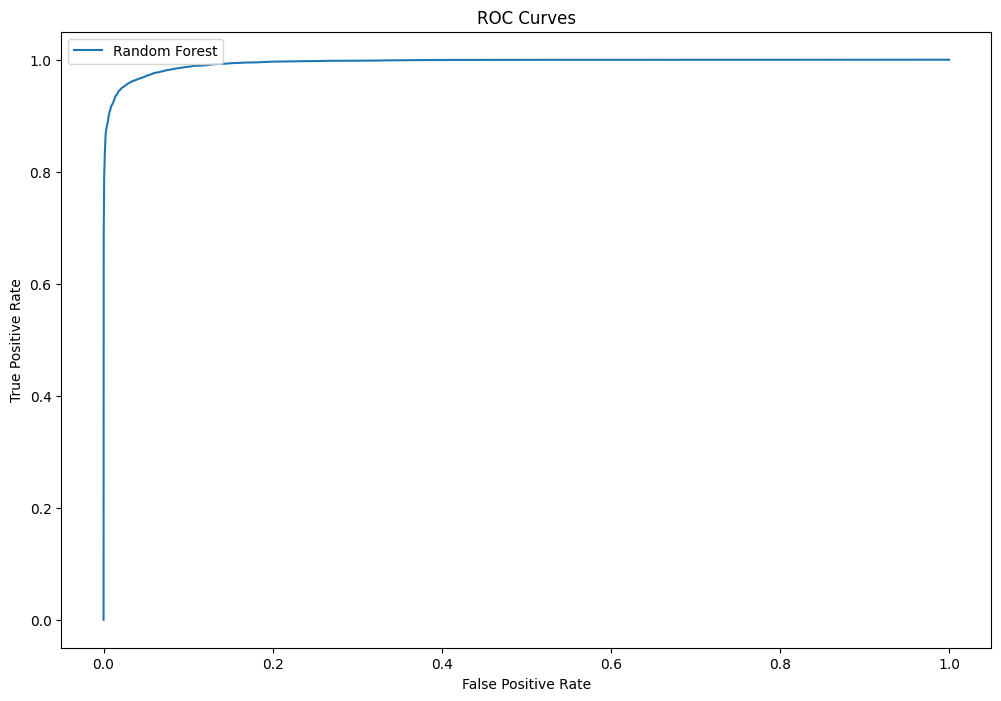

In [92]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_rf]:
    predictions = model.transform(testData).select("satisfactionIndex", "probability").withColumn('satisfactionIndex', f.col('satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['satisfactionIndex'])))
    points = CurveMetrics(predictions).get_curve('roc')
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Random Forest'])

In [93]:
rf = DecisionTreeClassifier(labelCol="satisfactionIndex", featuresCol="features",maxDepth=20 )
model_rf = rf.fit(trainingData)
rf_i = model_rf.featureImportances
importancesList=[float(col) for col in  rf_i]
colList = airline_upsample.columns
importances_rf=dict(zip(colList,importancesList))
print(importances_rf)

22/10/12 09:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1044.1 KiB
22/10/12 09:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1123.4 KiB
22/10/12 09:38:37 WARN DAGScheduler: Broadcasting large task binary with size 1198.8 KiB


{'GenderIndex': 0.00627672645843554, 'Customer_TypeIndex': 0.03234519283617857, 'Type_of_TravelIndex': 0.12689647632775333, 'ClassIndex': 0.03401696793665933, 'Departure/Arrival time convenientIndex': 0.01891764172466062, 'Ease of Online bookingIndex': 0.005982745880166178, 'Gate locationIndex': 0.026116696507451666, 'Food and drinkIndex': 0.012164479675956802, 'Online boardingIndex': 0.3569800410607678, 'Seat comfortIndex': 0.014024091093068328, 'Inflight entertainmentIndex': 0.04559907540855436, 'On-board serviceIndex': 0.014941928822774227, 'Leg room serviceIndex': 0.015412666145969369, 'Baggage handlingIndex': 0.022976442784959805, 'Inflight serviceIndex': 0.015767862224448183, 'CleanlinessIndex': 0.011449488354336986, 'Departure_DelayIndex': 0.010493150087377471, 'Arrival_DelayIndex': 0.013774030085250397, 'Inflight wifi serviceIndex': 0.18865656580040538, 'Checkin serviceIndex': 0.027207730784825607}


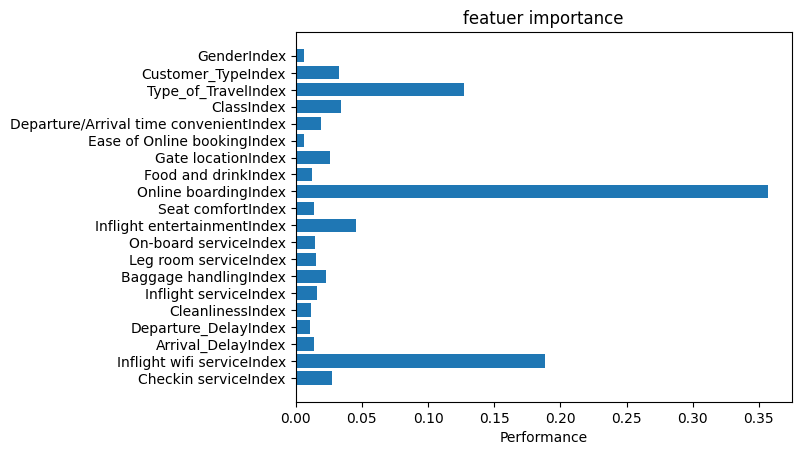

<Figure size 1000x700 with 0 Axes>

In [94]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig = plt.figure(figsize =(10, 7))
ax.barh(range(len(importances_rf)), importances_rf.values(), align='center')
ax.set_yticks(range(len(importances_rf)), labels=list(importances_rf.keys()))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('featuer importance')

plt.show()

In [96]:
model_rf.toDebugString

'DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1fc8c69596fc, depth=20, numNodes=6459, numClasses=2, numFeatures=20\n  If (feature 8 in {1.0,3.0,4.0,5.0})\n   If (feature 18 in {0.0,1.0,3.0})\n    If (feature 3 in {1.0,2.0})\n     If (feature 2 in {1.0})\n      Predict: 0.0\n     Else (feature 2 not in {1.0})\n      If (feature 1 in {1.0})\n       If (feature 13 in {0.0,2.0,3.0,4.0})\n        If (feature 11 in {0.0,2.0,3.0,4.0})\n         If (feature 14 in {0.0,2.0,3.0,4.0})\n          If (feature 19 in {0.0,1.0,3.0,4.0})\n           If (feature 6 in {0.0,1.0,2.0,4.0})\n            If (feature 11 in {2.0,3.0,4.0})\n             Predict: 0.0\n            Else (feature 11 not in {2.0,3.0,4.0})\n             If (feature 12 in {0.0,2.0,4.0})\n              Predict: 0.0\n             Else (feature 12 not in {0.0,2.0,4.0})\n              If (feature 9 in {0.0,1.0,2.0})\n               Predict: 0.0\n              Else (feature 9 not in {0.0,1.0,2.0})\n               If (feature 7

# itertation 1

In [101]:
vecAssembler = VectorAssembler(inputCols=airline_tidy_up.drop('satisfactionIndex').columns, outputCol='features')
data = vecAssembler.transform(airline_upsample)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())

86673


37127


In [102]:
grid = ParamGridBuilder().addGrid(dt.maxDepth, [10,15,20]).addGrid(dt.impurity,['gini','entropy']).build()
evaluator = MulticlassClassificationEvaluator(labelCol="satisfactionIndex", 
                                              predictionCol = "prediction", metricName = "accuracy")

cvModel_dt_i1 = CrossValidator(estimator=pipeline_dt, estimatorParamMaps = grid, 
                            evaluator =evaluator, numFolds = 3).fit(trainingData)

predictions_dt_i1 = cvModel_dt_i1.bestModel.transform(testData).select("satisfactionIndex", "prediction").withColumn('satisfactionIndex', f.col('satisfactionIndex').cast('double')).rdd
metrics_dt_i1 = MulticlassMetrics(predictions_dt_i1)

precision_acc(metrics_dt_i1.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_dt.accuracy,2)))



/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+---+---------+------+---+
|   |precision|recall| f1|
+---+---------+------+---+
|  0|     0.91|  0.89|0.9|
|  1|     0.88|  0.91|0.9|
+---+---------+------+---+



'Accuracy: 0.95'

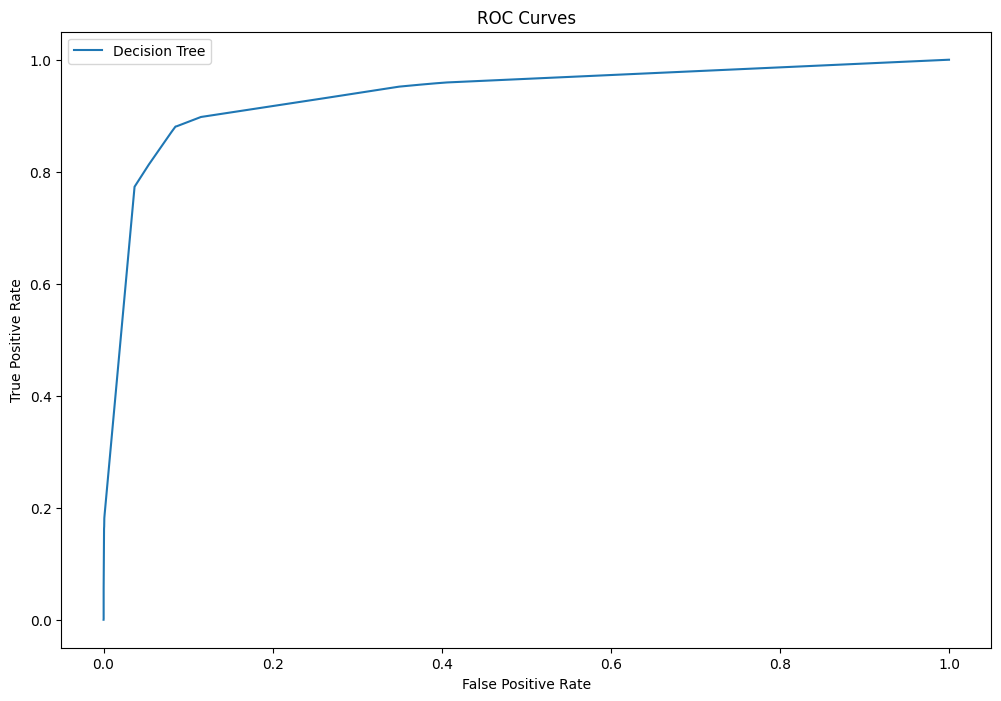

In [103]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_dt_i1]:
    predictions = model.transform(testData).select("satisfactionIndex", "probability").withColumn('satisfactionIndex', f.col('satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Decision Tree'])

# iteration 2

In [106]:
vecAssembler = VectorAssembler(inputCols=airline_upsample.drop('satisfactionIndex').columns, outputCol='features')
data = vecAssembler.transform(airline_upsample)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(trainingData.count())
print(testData.count())

86919


36881


In [107]:
grid = ParamGridBuilder().addGrid(dt.maxDepth, [10,15,20]).addGrid(dt.impurity,['gini','entropy']).build()
evaluator = MulticlassClassificationEvaluator(labelCol="satisfactionIndex", 
                                              predictionCol = "prediction", metricName = "accuracy")

cvModel_dt_i2 = CrossValidator(estimator=pipeline_dt, estimatorParamMaps = grid, 
                            evaluator =evaluator, numFolds = 10).fit(trainingData)

predictions_dt_i2 = cvModel_dt_i2.bestModel.transform(testData).select("satisfactionIndex", "prediction").withColumn('satisfactionIndex', f.col('satisfactionIndex').cast('double')).rdd
metrics_dt_i2 = MulticlassMetrics(predictions_dt_i2)

precision_acc(metrics_dt_i2.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_dt.accuracy,2)))


+---+---------+------+---+
|   |precision|recall| f1|
+---+---------+------+---+
|  0|     0.91|  0.89|0.9|
|  1|     0.88|  0.91|0.9|
+---+---------+------+---+



'Accuracy: 0.95'

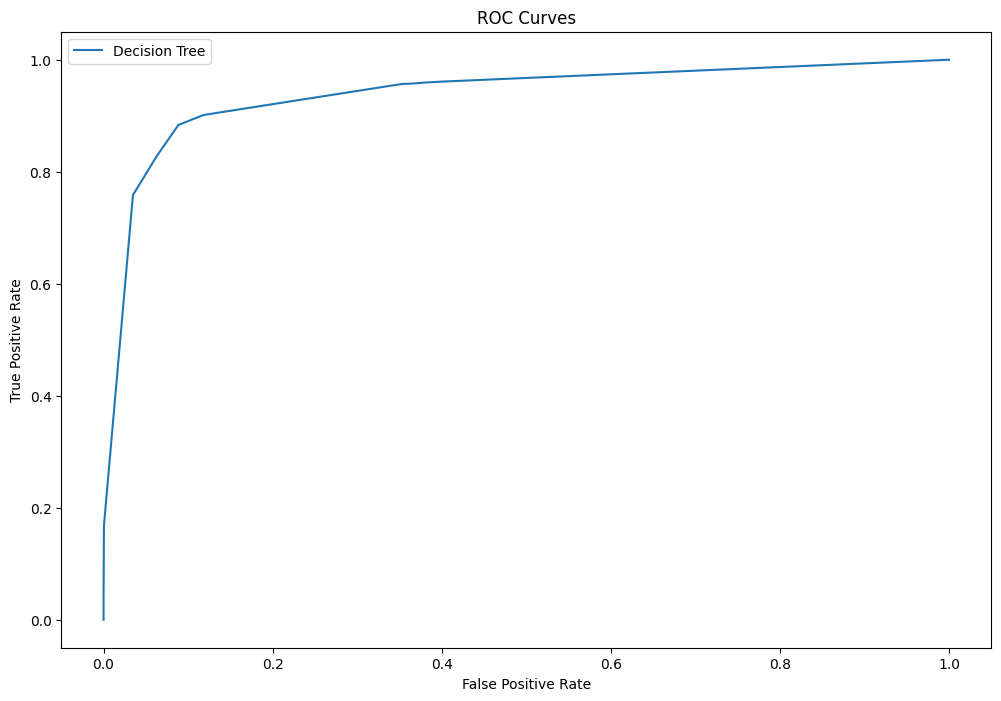

In [108]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_dt_i2]:
    predictions = model.transform(testData).select("satisfactionIndex", "probability").withColumn('satisfactionIndex', f.col('satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Decision Tree'])

# iteration 3

In [110]:
vecAssembler = VectorAssembler(inputCols=airline_upsample.drop('satisfactionIndex').columns, outputCol='features')
data = vecAssembler.transform(airline_upsample)
(trainingData, testData) = data.randomSplit([0.6, 0.4])
print(trainingData.count())
print(testData.count())

74212


49588


In [111]:
grid = ParamGridBuilder().addGrid(dt.maxDepth, [10,15,20]).addGrid(dt.impurity,['gini','entropy']).build()
evaluator = MulticlassClassificationEvaluator(labelCol="satisfactionIndex", 
                                              predictionCol = "prediction", metricName = "accuracy")

cvModel_dt_i3 = CrossValidator(estimator=pipeline_dt, estimatorParamMaps = grid, 
                            evaluator =evaluator, numFolds = 10).fit(trainingData)

predictions_dt_i3 = cvModel_dt_i3.bestModel.transform(testData).select("satisfactionIndex", "prediction").withColumn('satisfactionIndex', f.col('satisfactionIndex').cast('double')).rdd
metrics_dt_i3 = MulticlassMetrics(predictions_dt_i3)

precision_acc(metrics_dt_i3.confusionMatrix().toArray()).show()
display("Accuracy: {}".format(round(metrics_dt.accuracy,2)))

+---+---------+------+----+
|   |precision|recall|  f1|
+---+---------+------+----+
|  0|     0.91|  0.89| 0.9|
|  1|     0.88|  0.91|0.89|
+---+---------+------+----+



'Accuracy: 0.95'

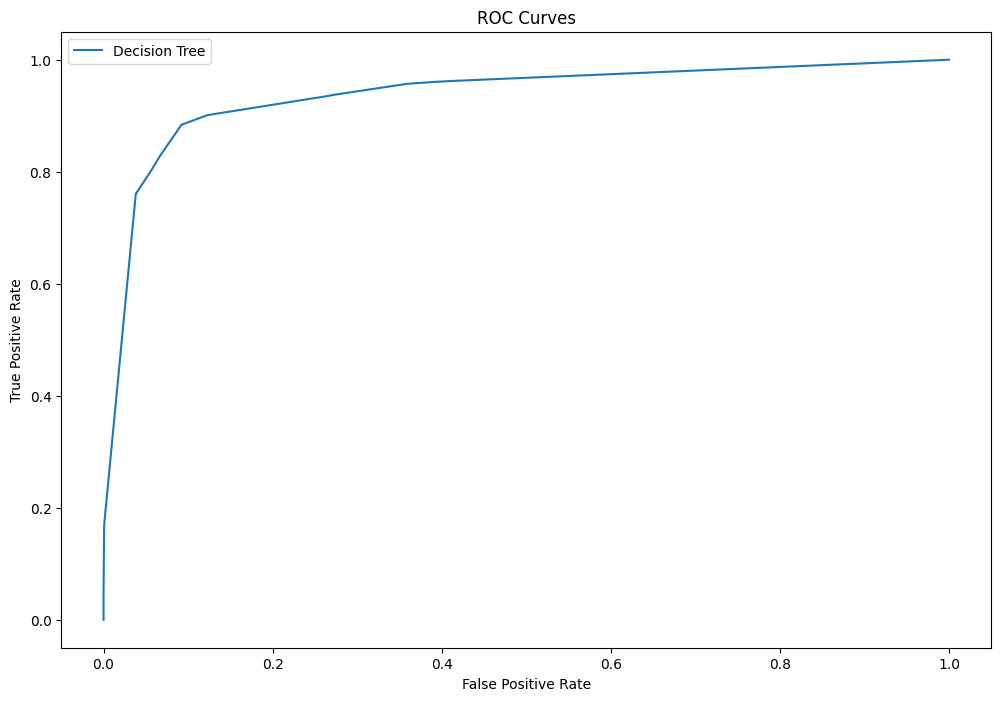

In [112]:
figure, ax = plt.subplots(figsize=(12,8))
plt.title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
for model in [cvModel_dt_i3]:
    predictions = model.transform(testData).select("satisfactionIndex", "probability").withColumn('satisfactionIndex', f.col('satisfactionIndex'). \
        cast('double')).rdd.map(lambda row: (float(row['probability'][1]), float(row['satisfactionIndex'])))
    points =CurveMetrics(predictions).get_curve('roc')
    x_val= [x[0] for x in points]
    y_val = [x[1] for x in points]
    ax.plot(x_val, y_val)
ax.legend(labels = ['Decision Tree'])